# Initialisations

In [105]:
import pandas as pd ; pd.set_option('display.max_columns', 500)
import numpy as np
from numpy import random ; random.RandomState(seed = 69)

from sklearn.model_selection import train_test_split

from sklearn import ensemble #gradientboosting
from sklearn import linear_model #lasso
from sklearn import tree #decision tree

from sklearn.metrics import mean_absolute_error
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import ipywidgets as widgets

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [67]:
csv = pd.read_csv('filtered_organics_desc_kh.csv') # contains VP/AS HLCs

print(csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print(csv.shape) #removed NaN shape

species_names = csv.pop('0')
smiles_strings = csv.pop('Unnamed: 0')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9', 'Index'], axis=1) #seperating features

(2075, 1480)
(2068, 1480)


In [68]:
X = dragon_features ; y = constants_first #renaming to X and y for use in models

## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

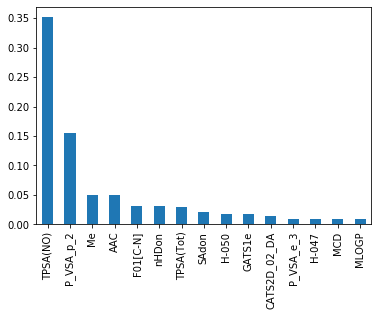

In [70]:
from sklearn.ensemble import GradientBoostingRegressor
fs_model = GradientBoostingRegressor()
fs_model.fit(X, y)
importances = pd.Series(fs_model.feature_importances_, index = X.columns)
importances.nlargest(15).plot(kind='bar')
plt.show()
top_15_features_model = list(importances.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

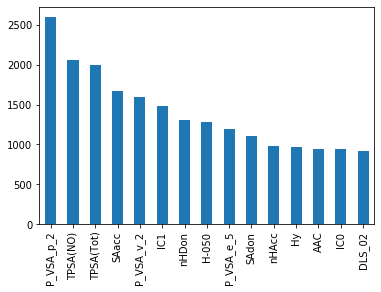

In [74]:
from sklearn.feature_selection import SelectKBest, f_regression

fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X, y)
scores_f = pd.Series(fit.scores_, index=X.columns)
scores_f.nlargest(15).plot(kind='bar')
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

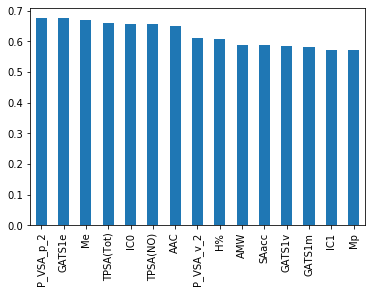

In [76]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X, y)
scores_mutual = pd.Series(fit.scores_, index=X.columns)
scores_mutual.nlargest(15).plot(kind='bar')
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

## GradientBoosting
Using grid search to find ideal hyperparameters

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)

model_gbr = ensemble.GradientBoostingRegressor()

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

grid_search_gbr = GridSearchCV(model_gbr, param_grid, n_jobs=2)

grid_search_gbr.fit(X_train, y_train)

gbr_hyperparams = grid_search_gbr.best_params_

print(gbr_hyperparams)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 1000}


Grid search completed 20:16 27/12/19 - results: <br>
`{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 1000}`

In [83]:
str(gbr_hyperparams)

"{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 1000}"

In [86]:
grad_boost = ensemble.GradientBoostingRegressor(learning_rate = 0.02,
                                                loss = 'lad',
                                                max_depth = 6,
                                                max_features = 0.3,
                                                min_samples_leaf = 3,
                                                n_estimators = 1000)
grad_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.02, loss='lad', max_depth=6,
                          max_features=0.3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [107]:
pred_list = []
for i in range(0, len(X[top_15_features_model])):
    prediction = grad_boost.predict([X[top_15_features_model].iloc[i]])
    pred_list.append(prediction)
    
exp_vs_calc_gbr = pd.DataFrame(y)
exp_vs_calc_gbr['Predicted'] = pred_list
exp_vs_calc_gbr.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
exp_vs_calc_gbr.head()

,Experimental,Predicted
0,11.176453,[10.314193241128162]
1,10.871072,[10.099120534897242]
2,11.107460,[11.106834746621065]
3,11.330604,[11.331472148301419]
4,11.607236,[11.331472148301419]


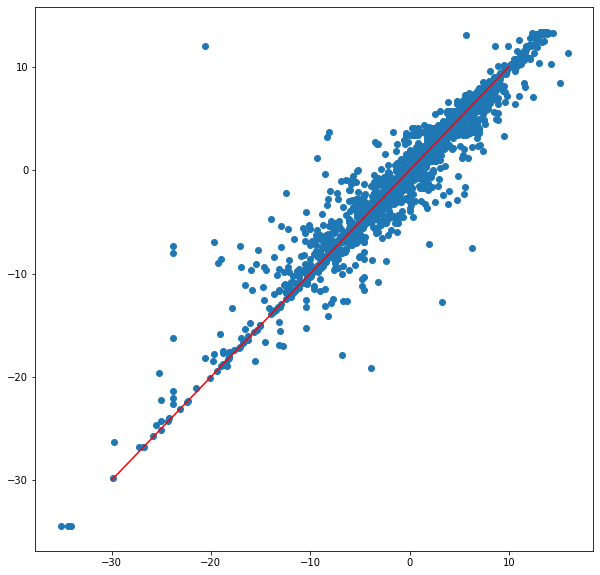

In [111]:
fig = plt.figure(figsize=(10, 10))
scatter = plt.scatter(exp_vs_calc_gbr['Experimental'], exp_vs_calc_gbr['Predicted'])
labels = ['{}'.format(i) for i in species_names]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
plt.plot([-30, 10], [-30, 10], c='red')
plt.show()

In [112]:
print('Training Score:\t', grad_boost.score(X_train, y_train))
print('Testing Score:\t', grad_boost.score(X_test, y_test))

Training Score:	 0.9584582349647759
Testing Score:	 0.8385490097615664


In [ ]:
joblib.dump(grad_boost, 'gradientboosting_modelimportances_')